# Regression

This notebook is designed to be a starting point, the hello world scenario, of a regression problem
We try to keep this up to date with best practices, such that it is easy to get an initial model trained, with sufficient endpoints to then start customizing and tuning the pipeline to your specific situations.

The notebook is tailored for the case where you get a labelled trainingset and an unlabeled 'challenge' set. This is slightly different from a testset, because usually you do have the labels of the test set, but you just use them to determine a quality measure.

In [1]:
import os
print os.getcwd()

/Users/gerben/Projects/bdr-analytics-py/notebooks


We here import bdr-analytics -py from a local checkout. This is not necessary if it is installed in your (conda) environment.

In [2]:
import sys
sys.path.append("../../bdr-analytics-py")
%load_ext autoreload
%autoreload 2

In [3]:
# import generic packages
import numpy as np
import pandas as pd
from IPython.display import display

# visualization packages
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, Imputer, StandardScaler
from bdranalytics.pipeline.encoders import WeightOfEvidenceEncoder
from bdranalytics.pipeline.encoders import ColumnSelector, StringIndexer
from bdranalytics.pandaspipeline.transformers import PdFeatureUnion
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score

## Data load

In [5]:
from sklearn.datasets import load_boston

raw = load_boston()
df = pd.DataFrame(raw['data'], columns=raw['feature_names'])
df['TARGET'] = raw['target']
# for educational purpose, let us add a date
ts = pd.date_range('1/1/2011', periods=len(df), freq='H').strftime('%Y-%m-%d %H:%M:%S')
np.random.shuffle(ts)
df['example_date'] = ts
# for educational purposes, let us add a category
cat = np.floor(df['AGE'] % 6)
df['example_cat'] = pd.Series(cat).map({0:'ZERO', 1:'UNO', 2:'TWO', 3:'TRES', 4:'QUAT', 5:'SIX'})
# for educational purposes, let us add a very high cardinality category
df['example_cardinalcat'] = pd.Series(np.floor(df.index.values**2)).astype(str)+'_str'
print("{:d} samples".format(len(df)))
df.index.name = 'INDEX'
df.head()

506 samples


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET,example_date,example_cat,example_cardinalcat
INDEX,,,,,,,,,,,,,,,,,
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,2011-01-03 02:00:00,SIX,0.0_str
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,2011-01-15 00:00:00,ZERO,1.0_str
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,2011-01-18 03:00:00,UNO,4.0_str
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,2011-01-18 02:00:00,TRES,9.0_str
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,2011-01-18 20:00:00,ZERO,16.0_str


In [6]:
labelled = df.iloc[:-100,:]
challenge = df.iloc[-100:,:]

Note: if you have a dataset without labels, assign it to `challenge`, the `labelled` set is the set using which we train (and where we extract a testset from).

## Problem definition

Remove the target column from the train dataset

In [7]:
y_col = 'TARGET'
X = labelled.reset_index().drop([y_col, labelled.index.name], 1).copy()
y = labelled[y_col].copy()
# assign items to groups, train and test set will be stratified selection from groups
groups = np.random.randint(1, 10, len(y)) # here we define random groups, could also be the class index taken from X

In [8]:
def root_mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(mean_squared_error(y_true, y_pred, sample_weight, multioutput))

In [9]:
model_score = root_mean_squared_error
model_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

### Data load check

Print some values to get some shallow information about the data set (that's why we haven't extracted a test set yet)

In [10]:
display(X.head())
print(X.columns.values)
display(y.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,example_date,example_cat,example_cardinalcat
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,2011-01-03 02:00:00,SIX,0.0_str
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,2011-01-15 00:00:00,ZERO,1.0_str
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,2011-01-18 03:00:00,UNO,4.0_str
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,2011-01-18 02:00:00,TRES,9.0_str
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,2011-01-18 20:00:00,ZERO,16.0_str


['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT' 'example_date' 'example_cat' 'example_cardinalcat']


INDEX
0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: TARGET, dtype: float64

## Data profile

We now will generate a generic data profile report.
The information in this report can help with choices for your feature generation. Thus take note of nr of unique values and nr of missing values.

In [11]:
from pandas_profiling import ProfileReport

profile = ProfileReport(X, correlation_overrides=list(X.columns))
profile

/Users/gerben/anaconda3/envs/bdranalytics/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Number of variables,16
Number of observations,406
Total Missing (%),0.0%
Total size in memory,50.8 KiB
Average record size in memory,128.2 B
Numeric,13
Categorical,1
Date,0
Text (Unique),2
Rejected,0
Distinct count,309


## Defining our row based feature generation
Feature generation can be divided into two different types, the **row based** which can be applied row by row, and the **model based** for which first all rows need to be analyzed.

An example of a **row based** feature generation is changing a string column containing a date time string, into columns containing the year, month, day, hour and minute, as this can be determined using only information within the row.

An example of a **model based** feature generation is changing a string column containing a users response, into a bag of words, as one needs to scan the full dataset to know which words are possible.

Applying a one-hot encoding can be either one. If one is quite sure all possible values are in the dataset, or one knows the possible values in advance, it is **row based**. A good example is the gender field with only *Male* or *Female*. If the values can be practically anything, it needs to be regarded **model based**. A good example is the city field of an address, or the postal code. Both are theoretically limited, but usually not all values are used in the dataset. As a general rule, if you really need to check which values are actually possible, it is **model based**.

The importance of this is the fact that **row based** feature generation can be applied before the train/test split, while the **model based** feature generation needs to be part of the model train pipeline.

 
**Note : we first define transforms, and only at the end we apply them**
In this way we force ourselves to have a repeatable function, which we can also apply on the **challenge** dataset.

### Checking data types and especially categoricals
Based on the pandas dtypes we can divide the columns in different sets, and have a closer look into the categoricals.
Especially the number of unique values per categorical column:
 * For very very high numbers, we will regard them identifiers, and remove them here
 * For very high numbers, we will use a Weight of Evidence transformer in the pipeline
 * For the other columns we will apply the regular OneHotEncoder.

A note about identifiers: If a single value of a column can only map to a very small number of rows, these will trick the model in learning a map from id to value. Typical of such columns are the user id, address, but also timestamp.

In [12]:
booleans = []

numericals =  X.select_dtypes(include=['float']).columns.values.tolist()
print("Numericals:")
display(numericals)
print("Categoricals with # unique values:")
categoricals = X.select_dtypes(include=['object']).columns.values.tolist()
display(X[categoricals].apply(lambda s: len(s.unique())))

unknowns = list(set(X.columns.values.tolist())-set(numericals)-set(categoricals))
if(len(unknowns)>0):
    print("Columns of unhandled type:")
    print(X.loc[:,unknowns].dtypes)
    assert(len(unknowns)==0)

Numericals:


['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

Categoricals with # unique values:


example_date           406
example_cat              6
example_cardinalcat    406
dtype: int64

### Parsing dates

Dates just by themselves are often too unique, but can hold valueable information. As the parts are circular variables (24H is equal to 0H), we can tranform them while maintaining that aspect. Otherwise, parts can be one-hot encoded. As these are decisions to be made, we postpone them to **after** the train-test split.

What we do define now, is how to parse the dates we want to keep, and determine which dates we would remove unused.

In [13]:
dates = ['example_date']
display(X[dates].head(5))

,example_date
0,2011-01-03 02:00:00
1,2011-01-15 00:00:00
2,2011-01-18 03:00:00
3,2011-01-18 02:00:00
4,2011-01-18 20:00:00


Now we define the format to be able to parse them. Check http://strftime.org/ for more details about formatting

In [14]:
date_formats = {
   'example_date' : '%Y-%m-%d %H:%M:%S'
}
# verify parsing of all defined date_formats:
for col_name, col_format in date_formats.items():
    display(
        pd.to_datetime(
            X[col_name], 
            format=col_format 
            ).head(5))

0   2011-01-03 02:00:00
1   2011-01-15 00:00:00
2   2011-01-18 03:00:00
3   2011-01-18 02:00:00
4   2011-01-18 20:00:00
Name: example_date, dtype: datetime64[ns]

### Defining identifiers
The identifiers have too high cardinality, resembling too much like identifiers.

Now we remove from the categorical columns the ones we regard **identifiers** or **highlycategoricals**

In [15]:
identifiers = ['example_date']
identifiers = list( set(identifiers) - set(dates)) # remove the dates that will be transformed into lower cardinality

### Defining 'highly' categoricals

And we also remove from the categorical columns the ones we regard **highlycategoricals**

In [16]:
highlycategoricals = ['example_cardinalcat']

### Defining regular categoricals
Now we remove from the categorical columns the ones we regard **identifiers** or **highlycategoricals**, so we end with the 'regular' categoricals

In [17]:
categoricals = list(set(categoricals) - set(highlycategoricals) - set(identifiers) - set(dates))

### Summary of column types

Now we've got the columns divided into the following groups. These can then be used to apply different model pipelines:

In [18]:
print("The identifiers (we will remove them):")
display(identifiers)
print("Dates (to parse and further process):")
display(dates)
print("Numericals:")
display(numericals)
print("The selected highly categoricals")
display(highlycategoricals)
print("The remaining regular categoricals")
display(categoricals)

The identifiers (we will remove them):


[]

Dates (to parse and further process):


['example_date']

Numericals:


['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

The selected highly categoricals


['example_cardinalcat']

The remaining regular categoricals


['example_cat']

## Applying row based feature generation
The previous code blocks only defined the changes, now we apply them in a repeatable way: they also have to be applied on new datasets, such as the **challenge** dataset.

In [19]:
def featurize(input_dataframe):
    """Applies all the model-less / row based feature generation on the provided pandas dataframe"""
    df = input_dataframe.copy()
    
    # handling identifiers 
    print "Removing identifier columns: {}".format(", ".join(identifiers))
    df.drop(identifiers, axis=1, inplace=True)
    
    # handling dates
    for col_name in dates:
        print "Parsing dates in column {}. Will show some examples when done:".format(col_name)
        col_format = date_formats[col_name]
        df[col_name] = pd.to_datetime(
            df[col_name], 
            format=col_format
            )
        display(X[col_name].head(5))
        
    return df

In [20]:
X = featurize(X)
challenge = featurize(challenge)

Removing identifier columns: 
Parsing dates in column example_date. Will show some examples when done:


0    2011-01-03 02:00:00
1    2011-01-15 00:00:00
2    2011-01-18 03:00:00
3    2011-01-18 02:00:00
4    2011-01-18 20:00:00
Name: example_date, dtype: object

Removing identifier columns: 
Parsing dates in column example_date. Will show some examples when done:


0   2011-01-03 02:00:00
1   2011-01-15 00:00:00
2   2011-01-18 03:00:00
3   2011-01-18 02:00:00
4   2011-01-18 20:00:00
Name: example_date, dtype: datetime64[ns]

## Divide data into train / validate / test

### Definitions
We start with two datasets: define the following datasets:
 * **labelled**     : the full labelled train set, using which the final model will be trained
 * **challenge** : the data without labels, which will be labelled by the final model

To develop the final model, we divide the labelled dataset into three parts:
 * **train** : Used to train different candidate models, or one model with different (meta)parameters
 * **validate** : Used to evaluate a candidate model, and then to choose one of those options as 'the final' model
 * **test** : Our own hold out set to evaluate the final model on, such that we get an estimate of it's performance.

In the 3 split way, there is only one validation set, which is only part of the full dataset. A different approach is to use cross validation, with multiple validation sets, in total covering the full dataset, such that a more accurate estimate of the performance can be determined. Therefore we also define :
 * The dataset **dev** : The development dataset, consisting of both the **train** and **validate** set.
 * The fold generator **cv_dev** : which is designed to work on the **dev** dataset

### Split generators

Let's now divide the datasets and create a cross fold generator

In [21]:
#from bdranalytics.model_selection.growingwindow import IntervalGrowingWindow
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV

cv_dev = GroupShuffleSplit(n_splits=5, test_size=0.1, train_size=0.3, random_state=11)

def train_test_split(X, y, groups):
    """Splits the labelled set X (by y) in two parts, one for training, one for testing.
    The function centralizes the decisions related to the specific dataset in this notebook.
    It takes care of required ordering (if applicable) and stratification (if applicable)"""
    cv_test = GroupShuffleSplit(n_splits=1, test_size=0.1, train_size=None, random_state=22)
    return next(cv_test.split(X, y, groups=groups)) # take the first (and only) split

We just created **cv_dev** , which creates k fold cross validation sets within the **dev** dataset.

### Applying the split generators on the datasets

First we divide the full labelled dataset into a **dev** and a **test** set

In [22]:
dev_indices, test_indices = train_test_split(X, y, groups)
X_dev = X.iloc[dev_indices,:]
y_dev = y[dev_indices]
groups_dev = groups[dev_indices]

X_test = X.iloc[test_indices]
y_test = y[test_indices]
groups_test = groups[test_indices]

Next we divide the **dev** set into a **train** and **validate** set

In [23]:
train_indices, validate_indices = train_test_split(X_dev, y_dev, groups_dev)

X_train = X_dev.iloc[train_indices,]
y_train = y_dev[train_indices]
groups_train = groups_dev[train_indices]

X_validate = X_dev.iloc[validate_indices,]
y_validate = y_dev[validate_indices]
groups_validate = groups_dev[validate_indices]

## Custom feature generations
Now we define custom feature generations / transformation for this use case, which might be included in the pipelin

In [24]:
from bdranalytics.pandaspipeline.transformers import PdFeatureUnion
from bdranalytics.pdpreprocessing.encoders import DateOneHotEncoding, DateCyclicalEncoding
from sklearn.preprocessing import MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold

## Feature generation pipeline

In [25]:
transformer_steps = [
        # Weight of evidence needs to be BEFORE FeatureUnion, because it needs a dataframe
        # It also works on ALL columns, and replaces the transformed columns (so no columnselector necessary)
        WeightOfEvidenceEncoder(cols=highlycategoricals), 
        PdFeatureUnion([ # Union of features with retention of column names
            # one hot encoding of dates
            ('dates1', Pipeline([
                        ('selector', ColumnSelector(columns=dates)),
                        ('dateencoder', DateOneHotEncoding(dates, drop=True, parts=['DAY_OF_WEEK']))
                        ])),
            # cyclical encoding of dates
            ('dates2', Pipeline([
                        ('selector', ColumnSelector(columns=dates)),
                        ('dateencoder', DateCyclicalEncoding(dates, drop=True, parts=['DAY'])), # drops the original dates
                        ])),
#            ('booleans', Pipeline([
#                       ('selector', ColumnSelector(columns=booleans)),
#                   ])),  # booleans close
            ('categoricals', Pipeline([
                        ('selector', ColumnSelector(columns=categoricals)),
                        ('labeler', StringIndexer()),
#                                 ('labeler', LabelEncoder()),
                        ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
                    ])),  # categoricals close                    
            ('numericals', Pipeline([
                        ('selector', ColumnSelector(columns=numericals)),
                        ('imputer', Imputer()),
                        ('scaler', StandardScaler())
                    ])), # numericals close
             ]),
         # TODO: unfortunately the Imputer kills the column names
        Imputer(missing_values='NaN', strategy='mean'), # you probably want something better
        VarianceThreshold(threshold=0.0), # remove constant columns
        MaxAbsScaler() # scale the features while preserving sparsity to allow regularization
]
transformer = make_pipeline(*transformer_steps)

In [26]:
transformer = transformer.fit(X_dev, y_dev)

In [27]:
X_dev_transformed = pd.DataFrame(transformer.transform(X_dev)) #.iloc[:,:])
print(X_dev_transformed.columns)

RangeIndex(start=0, stop=28, step=1)


In [28]:
assert len(X_dev)==len(X_dev_transformed), "length shouldnt change, means concat went wrong"

In [29]:
profile_dev = ProfileReport(X_dev_transformed, correlation_overrides=list(X_dev_transformed.columns))
profile_dev

Number of variables,28
Number of observations,356
Total Missing (%),0.0%
Total size in memory,77.9 KiB
Average record size in memory,224.2 B
Numeric,28
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,3


## (cross) Evaluate different models

Create a cross-validation routine for parameter tuning

Let's define our search space

In [30]:
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# specification of different model types and their defaults
# We use factory methods to prevent having to hold all models in memory
model_instances = {'lr': lambda : SGDRegressor(loss='squared_loss'),
                    'xgb': lambda: XGBRegressor(n_estimators=100,
                                        objective='reg:linear', #'reg:gamma'
#                                         max_depth=9, 
#                                         reg_alpha=15,
#                                         reg_lambda=5, 
#                                         gamma=0.5
                                       ),
                    'gb': lambda : GradientBoostingRegressor(n_estimators=10),
                    'rf' : lambda : RandomForestRegressor(),
                    'dummy': lambda : DummyRegressor(strategy='mean')
                   }

# specification of the different model hyperparameters and tuning space
model_params_grid = {'lr': {'alpha': [1e-5, 1e-4, 1e-3]},
                     'xgb': {
                             'max_depth': [3,6,9],
                             'reg_alpha': [0,5,15],
                             'reg_lambda': [0,5,15],
                             'gamma' : [0,0.5,5,50],
                            },
                     'gb' : {'n_estimators' : [10, 50, 100],
                            'max_depth' : [3, 5, 7, 10]},
                     'rf' : {'n_estimators' : [10],
                            'max_depth' : [3, 5, None]},
                     'dummy': {'strategy':['mean','median']}
                    }

/Users/gerben/anaconda3/envs/bdranalytics/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Now we have pipeline steps for feature generation, and different final steps for model choices, each with a different parameter tuning grid

In [31]:
n_jobs = 1 # note that this also affects used memory
def change_param_keys(named_step, param_dict):
    return {'regressor__{}'.format(key):val for key,val in param_dict.items()}

def grid_search(model_name, model_instance):
    print "=== Tuning parameters for {} ===".format(model_name)
    estimator = Pipeline([('featurizer', make_pipeline(*transformer_steps)), ('regressor', model_instance)])
    estimator_param_grid = change_param_keys('regressor',model_params_grid[model_name])
    gridsearch = GridSearchCV(estimator, 
                               cv=cv_dev, n_jobs=n_jobs, refit=False,
                               param_grid=estimator_param_grid,
                               scoring=model_scorer,
                               verbose=1)

    gridsearch.fit(X_dev, y_dev, groups=groups_dev)
    # show grid search results
    display(pd.DataFrame(gridsearch.cv_results_).sort_values('rank_test_score').head())
    print gridsearch.best_params_
    return gridsearch

In [32]:
model_tune = {}
for (model_name, model_instance_create) in model_instances.items():
    gridsearch = grid_search(model_name, model_instance_create())
    model_tune[model_name] = {
        'best_params' : gridsearch.best_params_,
        'best_score' : gridsearch.best_score_
    }
    # set best parameters for estimator
    #estimator.set_params(**grid_search.best_params_)

=== Tuning parameters for xgb ===
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   49.6s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regressor__gamma,param_regressor__max_depth,param_regressor__reg_alpha,param_regressor__reg_lambda,params,rank_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
55,0.042671,0.013428,-4.388511,-1.433428,5,3,0,5,"{u'regressor__gamma': 5, u'regressor__reg_lamb...",1,...,-4.048043,-1.243772,-3.245698,-1.481906,-4.663778,-1.481906,0.001404,0.000545,0.677906,0.099037
64,0.050766,0.013455,-4.395936,-1.284148,5,6,0,5,"{u'regressor__gamma': 5, u'regressor__reg_lamb...",2,...,-3.999686,-1.140479,-3.301801,-1.354247,-4.595167,-1.354247,0.004127,0.000614,0.679038,0.082119
73,0.060989,0.013164,-4.413423,-1.270211,5,9,0,5,"{u'regressor__gamma': 5, u'regressor__reg_lamb...",3,...,-3.999686,-1.140479,-3.344815,-1.313139,-4.603852,-1.313139,0.002312,0.000450,0.672446,0.075671
1,0.045600,0.014454,-4.429830,-1.178690,0,3,0,5,"{u'regressor__gamma': 0, u'regressor__reg_lamb...",4,...,-4.070631,-0.638417,-3.398927,-1.308871,-4.702658,-1.308871,0.001869,0.001225,0.625460,0.275317
0,0.046628,0.022545,-4.438206,-0.289423,0,3,0,0,"{u'regressor__gamma': 0, u'regressor__reg_lamb...",5,...,-4.141463,-0.231305,-3.504854,-0.281575,-4.353119,-0.281575,0.005129,0.017709,0.696072,0.035388


{'regressor__gamma': 5, 'regressor__reg_lambda': 5, 'regressor__reg_alpha': 0, 'regressor__max_depth': 3}
=== Tuning parameters for rf ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.7s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regressor__max_depth,param_regressor__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.059041,0.018021,-4.759744,-2.512890,None,10,"{u'regressor__n_estimators': 10, u'regressor__...",1,-4.771597,-2.572566,...,-3.951797,-1.882513,-4.288435,-2.685051,-4.984095,-2.570741,0.002747,0.000303,0.656705,0.331659
1,0.059661,0.020213,-5.004089,-2.413691,5,10,"{u'regressor__n_estimators': 10, u'regressor__...",2,-4.545730,-2.077193,...,-4.036492,-2.551206,-5.263249,-2.223789,-4.973571,-2.502379,0.003040,0.001467,0.756992,0.230732
0,0.067759,0.021241,-5.046437,-3.129457,3,10,"{u'regressor__n_estimators': 10, u'regressor__...",3,-5.288711,-3.345931,...,-3.988998,-2.579392,-4.545092,-3.010700,-4.960754,-3.475108,0.010575,0.002391,0.868137,0.314450


{'regressor__n_estimators': 10, 'regressor__max_depth': None}
=== Tuning parameters for lr ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.1s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regressor__alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.031482,0.012905,-8.023576,-7.825222,0.0001,{u'regressor__alpha': 0.0001},1,-8.674259,-7.073379,-6.216955,...,-7.918029,-7.533113,-8.397907,-8.336502,-8.646544,-8.362686,0.001680,0.000876,0.882133,0.490080
2,0.032978,0.013738,-8.028749,-7.852340,0.001,{u'regressor__alpha': 0.001},2,-8.604921,-7.071523,-6.198867,...,-7.974245,-7.646163,-8.392506,-8.285071,-8.700496,-8.370655,0.001991,0.000936,0.886364,0.471038
0,0.033265,0.013458,-8.056269,-7.887549,1e-05,{u'regressor__alpha': 1e-05},3,-8.635788,-7.112510,-6.299914,...,-8.036709,-7.668393,-8.478160,-8.402212,-8.579684,-8.340494,0.001869,0.001030,0.842324,0.473172


{'regressor__alpha': 0.0001}
=== Tuning parameters for gb ===
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    5.6s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regressor__max_depth,param_regressor__n_estimators,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.057706,0.014301,-4.179133,-0.289423,3,100,"{u'regressor__n_estimators': 100, u'regressor_...",1,-4.049145,-0.322062,...,-4.177120,-0.231304,-3.317813,-0.281575,-3.949781,-0.281575,0.003311,0.001230,0.721470,0.035388
1,0.043864,0.013911,-4.284440,-0.747355,3,50,"{u'regressor__n_estimators': 50, u'regressor__...",2,-4.198106,-0.792572,...,-4.361917,-0.569113,-3.402843,-0.755770,-4.058877,-0.755770,0.003294,0.001229,0.684400,0.097425
5,0.067837,0.013007,-4.802713,-0.013278,5,100,"{u'regressor__n_estimators': 100, u'regressor_...",3,-3.773874,-0.014812,...,-4.621112,-0.006901,-4.030835,-0.012840,-5.256018,-0.012840,0.003344,0.000230,0.939355,0.003901
4,0.050138,0.012658,-4.869981,-0.132217,5,50,"{u'regressor__n_estimators': 50, u'regressor__...",4,-4.096214,-0.161193,...,-4.547366,-0.118021,-4.101961,-0.116804,-5.265640,-0.116804,0.000880,0.000364,0.871849,0.018834
3,0.035742,0.013151,-5.551529,-3.392144,5,10,"{u'regressor__n_estimators': 10, u'regressor__...",5,-5.596091,-3.359890,...,-5.094204,-3.165504,-5.306697,-3.427350,-5.962615,-3.427350,0.001424,0.000693,0.320141,0.134470


{'regressor__n_estimators': 100, 'regressor__max_depth': 3}
=== Tuning parameters for dummy ===
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_regressor__strategy,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.036664,0.014562,-9.390203,-9.062925,mean,{u'regressor__strategy': u'mean'},1,-9.847559,-8.957147,-7.898198,...,-9.691174,-8.719776,-9.634746,-8.976379,-9.678355,-8.976379,0.003712,0.001609,0.696170,0.325830
1,0.033785,0.014115,-9.616864,-9.261099,median,{u'regressor__strategy': u'median'},2,-9.930053,-9.095508,-8.254184,...,-10.067688,-8.919286,-9.787151,-9.133221,-9.861083,-9.133221,0.001245,0.000881,0.639253,0.389711


{'regressor__strategy': 'mean'}


In [33]:
model_tune

{'dummy': {'best_params': {'regressor__strategy': 'mean'},
  'best_score': -9.3902034558460716},
 'gb': {'best_params': {'regressor__max_depth': 3,
   'regressor__n_estimators': 100},
  'best_score': -4.1791334314564068},
 'lr': {'best_params': {'regressor__alpha': 0.0001},
  'best_score': -8.0235759616222158},
 'rf': {'best_params': {'regressor__max_depth': None,
   'regressor__n_estimators': 10},
  'best_score': -4.75974358276535},
 'xgb': {'best_params': {'regressor__gamma': 5,
   'regressor__max_depth': 3,
   'regressor__reg_alpha': 0,
   'regressor__reg_lambda': 5},
  'best_score': -4.3885109365170702}}

## Select the best model in the model search space

In [34]:
best_model_tune = max(model_tune.items(), key=lambda x:x[1]['best_score'])
display(best_model_tune)

('gb',
 {'best_params': {'regressor__max_depth': 3, 'regressor__n_estimators': 100},
  'best_score': -4.1791334314564068})

In [35]:
model_name = best_model_tune[0]
regressor = model_instances[model_name]() #the dict contains a function, need to instantiate it
estimator = Pipeline([('featurizer', make_pipeline(*transformer_steps)), ('regressor', regressor)])
estimator.set_params(**best_model_tune[1]['best_params'])

Pipeline(steps=[('featurizer', Pipeline(steps=[('weightofevidenceencoder', WeightOfEvidenceEncoder(cols=['example_cardinalcat'],
            dependent_variable_values=None, fillna=0, return_df=True,
            smooth=0.5, verbose=0)), ('pdfeatureunion', PdFeatureUnion(debug=False, n_jobs=None,
        trans...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

## Model Validation (cross validation)

In [36]:
estimator=estimator.fit(X_dev, y_dev)

In [37]:
from sklearn.model_selection import cross_val_predict
y_actual = y_dev
y_pred = cross_val_predict(estimator, X_dev, y_dev, groups=groups_dev, cv=5) #cannot use cv_dev as cross_val_predict doesn't like it

In [38]:
def plot_residualplot(y_actual, y_pred):
    g = sns.jointplot(y_actual, y_pred-y_actual)
    ax = g.ax_joint
    axes = ax.axes
    axes.set_xlim(np.percentile(y_actual, 1), np.percentile(y_actual, 99)) # remove outliers
    axes.set_ylabel('residuals (predicted-actual)')
    axes.set_xlabel('actual {}'.format(y_col))
    logscale = False
    if logscale:
        g.ax_joint
        ax = g.ax_joint
        ax.set_xscale('log')
        ax.set_yscale('log')
        g.ax_marg_x.set_xscale('log')
        g.ax_marg_y.set_yscale('log')

Target cost function <function root_mean_squared_error at 0x10e7e9848>:
5.15814921025


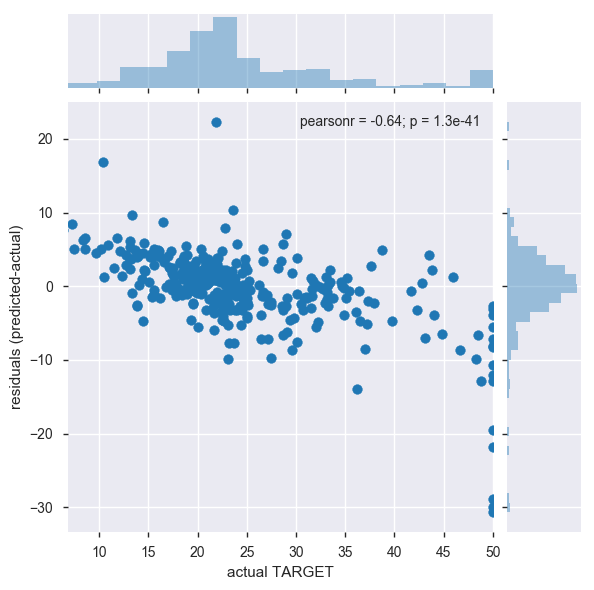

In [39]:
plot_residualplot(y_actual, y_pred)
print('Target cost function {}:'.format(model_score))
print(model_score(y_actual, y_pred))

## Model validation (hold-out)

Mean errors:


ABS_ERROR    1.985708
REL_ERROR    0.099894
dtype: float64

Median errors:


ABS_ERROR    1.408716
REL_ERROR    0.064722
dtype: float64

Target cost function <function root_mean_squared_error at 0x10e7e9848>:
3.25083236728


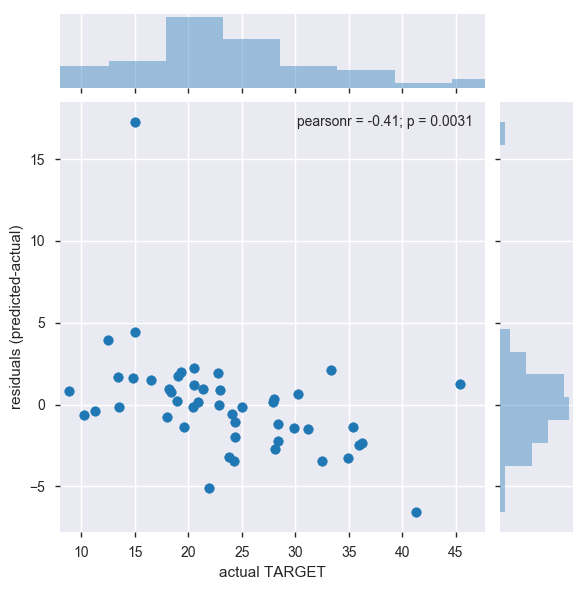

In [40]:
estimator = estimator.fit(X_dev, y_dev)
estimator_columns = pd.DataFrame(transformer.transform(X_dev)).columns
y_actual = y_test
y_pred = estimator.predict(X_test)

plot_residualplot(y_actual, y_pred)

results = pd.DataFrame(y_actual)
results['ACTUAL'] = results[[y_col]]
results['PREDICTION']=y_pred

results['ABS_ERROR'] = (results['ACTUAL'] - results['PREDICTION']).abs()
results['REL_ERROR'] = results['ABS_ERROR'] / results['ACTUAL']
print('Mean errors:')
display(results.filter(regex="ERROR").mean())
print('Median errors:')
display(results.filter(regex="ERROR").median())
print('Target cost function {}:'.format(model_score))
print(model_score(y_actual, y_pred))

In [41]:
estimator._final_estimator

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

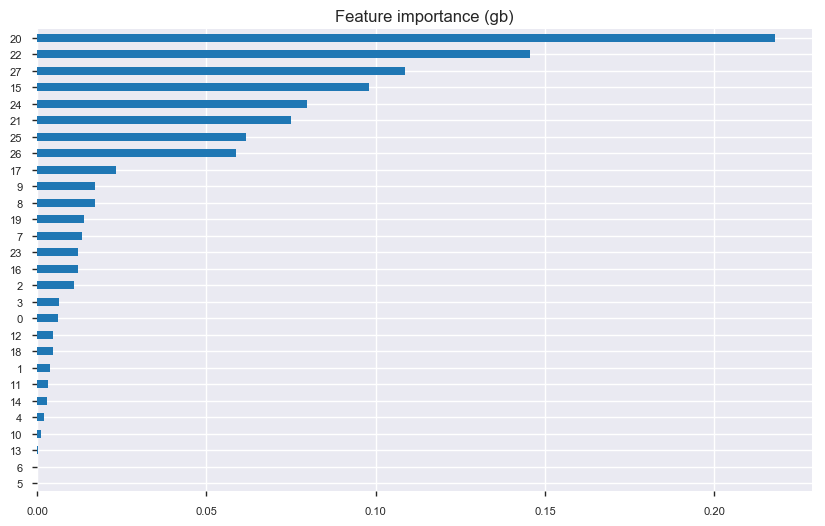

In [42]:
feature_labels = estimator_columns
n_features = len(estimator_columns)

if model_name is 'lr':
    weights = estimator._final_estimator.coef_[0]
elif model_name in ['rf','gb']:
    weights = estimator._final_estimator.feature_importances_
    #stdevs = np.std([tree.feature_importances_ for tree in estimator._final_estimator.estimators_], axis=0)
elif model_name is 'xgb':
    importance_dictionary = estimator._final_estimator.booster().get_score(importance_type='weight')
    weights = [value for (key, value) in sorted(importance_dictionary.items())]
elif model_name is 'dummy':
    print('DummyRegressor does not have weights')
    weights = np.zeros(n_features)

feature_weights = pd.Series(weights, index=feature_labels).sort_values()
feature_weights.plot.barh(title='Feature importance ({})'.format(model_name), fontsize=8, figsize=(10,6), grid=True);

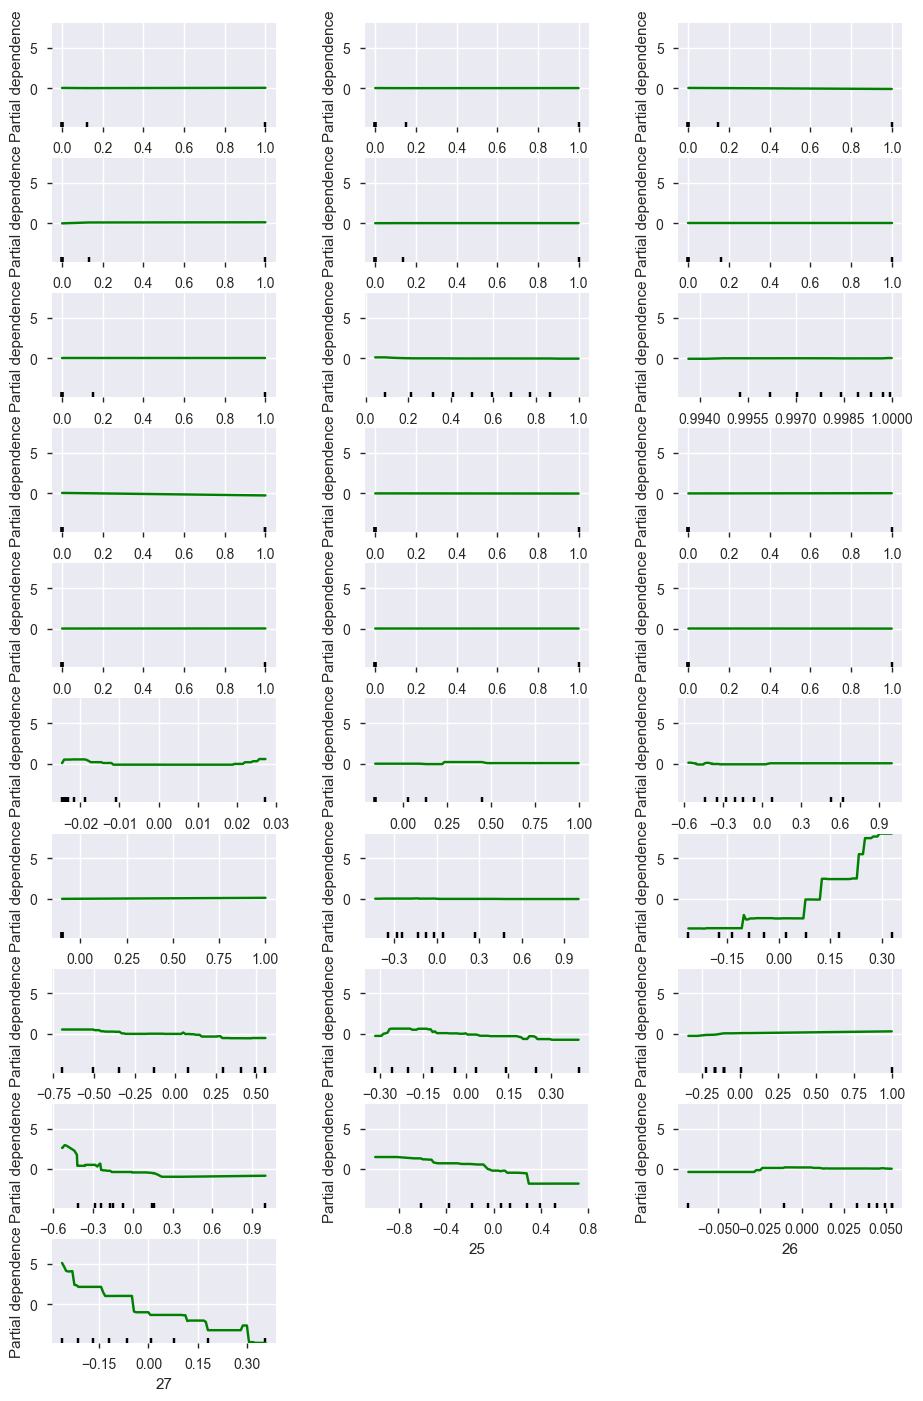

In [43]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

if model_name is 'gb':
    X_transformed = Pipeline(steps=estimator.steps[:-1]).fit_transform(X.iloc[dev_indices,:], y[dev_indices])
    plot_partial_dependence(estimator._final_estimator, X_transformed,
                            features=range(n_features), feature_names=feature_labels,
                            figsize=(10,24), n_cols=3, percentiles=(0.1,0.9));
else:
    print("No partial dependence plots available for model type {}".format(model_name))

## Fit the best model on the full labelled dataset

In [44]:
estimator_challenge=estimator.fit(X, y)

### Store the model for usage in different environments/pipelines

In [45]:
#import pickle
#import dill
#pickle.dump(estimator_challenge, open('../estimator.p', "wb" ), protocol=2)

# Predict CHALLENGE set
We assume that for the train, validate, and test set we actually have the true labels.
In challenges there is also a set which you need to predict, but don't have the actual labels for. Let's predict those, and output the result

In [46]:
y_challenge = estimator_challenge.predict(challenge)
challenge_out=pd.DataFrame({y_col:y_challenge}, index=challenge.index)
display(challenge_out.head())
challenge_out.to_csv('../challenge_out.csv',header=False,index=False)

,TARGET
INDEX,
406,12.089819
407,29.091209
408,11.100659
409,15.671439
410,28.523922


## Challenge validation

In [47]:
n_bins = 100
range_ratio=(n_bins*(max(y)-min(y))/(max(challenge_out.values)-min(challenge_out.values)))
print range_ratio

[ 169.13111865]


(7.2000000000000002, 50.0)


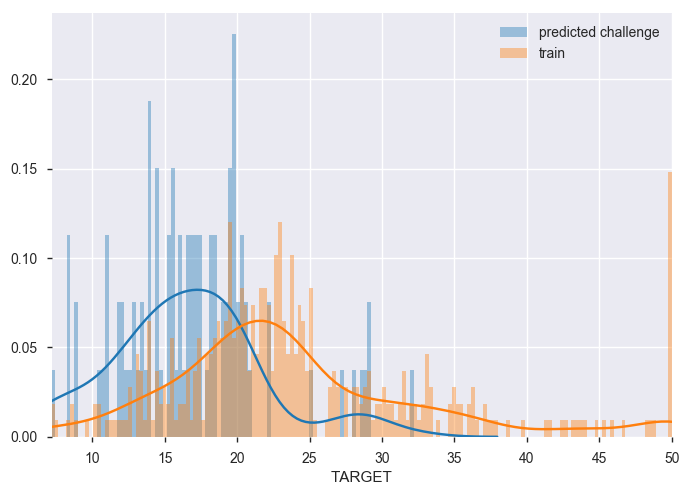

In [48]:
ax=sns.distplot(challenge_out, bins=n_bins, label='predicted challenge')
ax=sns.distplot(y, bins=int(range_ratio), label='train')
axes = ax.axes
axes.set_xlim(np.percentile(y, 1), np.percentile(y, 99))
print axes.get_xlim()
plt.legend();